# Demo

In [ ]:
# Basic libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
# Personalized modules
from preprocess.dataloader import AntibodiesTree
from preprocess.patches_utils import PatchesUtilities

from osgen.embedding import StyleExtractor
from osgen.utils import Utilities
from osgen.vae import VanillaVAE,VanillaEncoder
from osgen.base import BaseModel
from osgen.nn import *

/root/miniconda3/envs/biosgen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [5]:
# Directory where your tumor PNGs are stored
directory = '/root/BiOSGen/data/NKX3'

for filename in os.listdir(directory):
    if filename.endswith('.png') and 'NKX3' not in filename and 'NKX' in filename:
        new_filename = filename.replace('NKX', 'NKX3')
        old_path = os.path.join(directory, filename)
        new_path = os.path.join(directory, new_filename)
        os.rename(old_path, new_path)
        print(f'Renamed: {filename} -> {new_filename}')


Renamed: E11_TMA_15_02_IB_NKX.png -> E11_TMA_15_02_IB_NKX3.png
Renamed: E3_TMA_15_02_IVB_NKX.png -> E3_TMA_15_02_IVB_NKX3.png
Renamed: F12_TMA_15_02_IIB_NKX.png -> F12_TMA_15_02_IIB_NKX3.png
Renamed: F5_TMA_15_02_IIIB_NKX.png -> F5_TMA_15_02_IIIB_NKX3.png
Renamed: A3_TMA_15_02_IB_NKX.png -> A3_TMA_15_02_IB_NKX3.png
Renamed: N2_TMA_15_02_IB_NKX.png -> N2_TMA_15_02_IB_NKX3.png
Renamed: O11_TMA_15_02_IIIB_NKX.png -> O11_TMA_15_02_IIIB_NKX3.png
Renamed: D2_TMA_15_02_IIIB_NKX.png -> D2_TMA_15_02_IIIB_NKX3.png
Renamed: D5_TMA_15_02_IIB_NKX.png -> D5_TMA_15_02_IIB_NKX3.png
Renamed: S4_TMA_15_02_IB_NKX.png -> S4_TMA_15_02_IB_NKX3.png
Renamed: P9_TMA_15_02_IIIB_NKX.png -> P9_TMA_15_02_IIIB_NKX3.png
Renamed: L2_TMA_15_02_IIIB_NKX.png -> L2_TMA_15_02_IIIB_NKX3.png
Renamed: I9_TMA_15_02_IVB_NKX.png -> I9_TMA_15_02_IVB_NKX3.png
Renamed: G3_TMA_15_02_IVB_NKX.png -> G3_TMA_15_02_IVB_NKX3.png
Renamed: R4_TMA_15_02_IIB_NKX.png -> R4_TMA_15_02_IIB_NKX3.png
Renamed: E9_TMA_15_02_IIB_NKX.png -> E9_TMA_15_

In [7]:
# SRC antibodies
tree_src = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/HE",
    mask_dir = "/root/BiOSGen/data/tissue_masks/HE",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/HE"
)

# DST antibodies
tree_dst = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/NKX3",
    mask_dir = "/root/BiOSGen/data/tissue_masks/NKX3",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/NKX3"
)

# Print
print("Nb antibodies: ", tree_src.get_nb_antibodies())
print("Nb antibodies: ", tree_dst.get_nb_antibodies())

Nb antibodies:  248
Nb antibodies:  248


### Extract patches

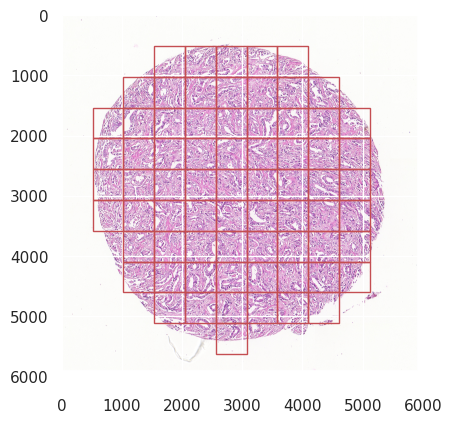

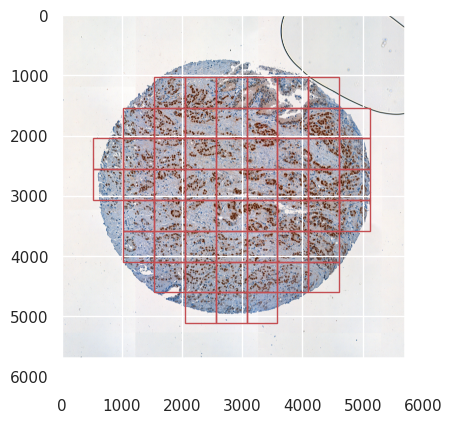

In [8]:
patches_src = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_src.antibodies[0])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[0]))),
)

patches_dst = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_dst.antibodies[0])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_dst.antibodies[0]))),
)

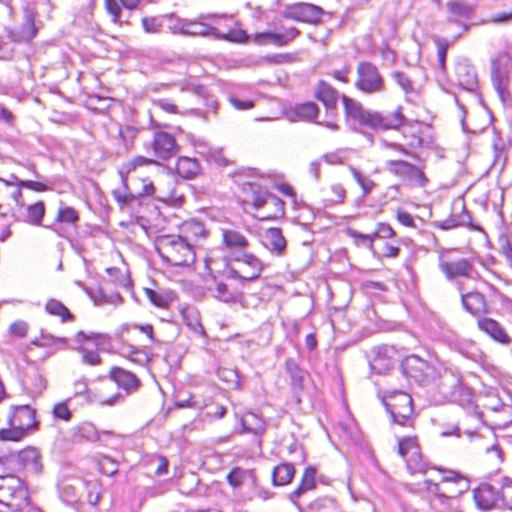

In [9]:
# Get patch to test
test_patch_src = patches_src[10]
Image.fromarray(test_patch_src)

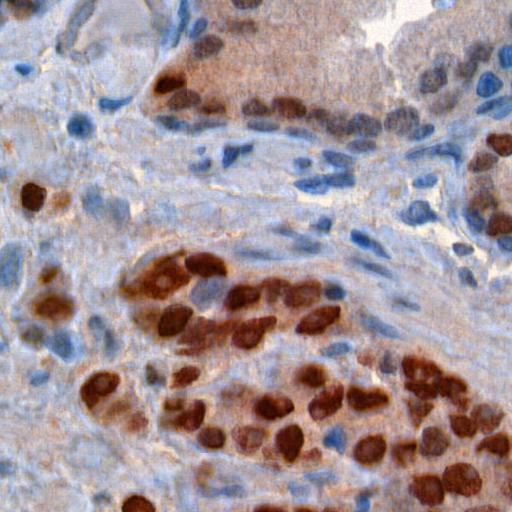

In [10]:
# Get patch to test
test_patch_dst = patches_dst[10]
Image.fromarray(test_patch_dst)

## Style extractor test

In [11]:
# Convert test patches to tensor
ut = Utilities()

test_patch_src_tensor = ut.convert_numpy_to_tensor(test_patch_src)
test_patch_dst_tensor = ut.convert_numpy_to_tensor(test_patch_dst)

print("test_patch_src_tensor shape: ", test_patch_src_tensor.shape)
print("test_patch_dst_tensor shape: ", test_patch_dst_tensor.shape)

test_patch_src_tensor shape:  torch.Size([1, 3, 512, 512])
test_patch_dst_tensor shape:  torch.Size([1, 3, 512, 512])


In [13]:
extractor = StyleExtractor()
style_emb = extractor(test_patch_dst_tensor)
print("out shape: ", style_emb.shape)

/root/miniconda3/envs/biosgen/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/biosgen/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 256MB/s]


out shape:  torch.Size([1, 512, 64, 64])


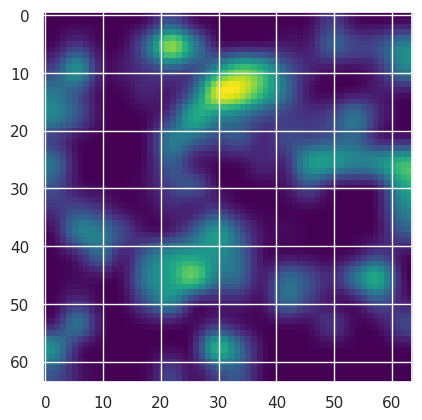

In [15]:
plt.imshow(style_emb[0, 0].detach().numpy(), cmap='viridis')

## Full VAE test

In [16]:
# Define model parameters
in_channels = 3
latent_dim = 512  # you can adjust this
hidden_dims = [32, 64, 128, 256]  # same as your encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Create dummy test input (or use your real tensor)
# test_patch_src_tensor = torch.randn(1, 3, 512, 512).to(device)

# Convert input tensor to device
test_patch_src_tensor = test_patch_src_tensor.to('cuda')

# 3. Instantiate the model
vae = VanillaVAE(
    in_channels=3,
    latent_dim=64,  # You can choose a different latent dimension
    hidden_dims=[32, 64]
).to(device)

vae.eval()

# 4. Forward pass
with torch.no_grad():
    [mu, log_var] = vae.encode(test_patch_src_tensor)

# print("Input shape:", input_tensor.shape)
# print("Reconstructed shape:", reconstructed.shape)
print("Latent mu shape:", mu.shape)
print("Latent log_var shape:", log_var.shape)

# 5. Compute loss (optional)?
# loss_dict = vae.loss_function(reconstructed, input_tensor, mu, log_var, M_N=1.0)
# print("Losses:", loss_dict)

Latent mu shape: torch.Size([1, 64, 128, 128])
Latent log_var shape: torch.Size([1, 64, 128, 128])


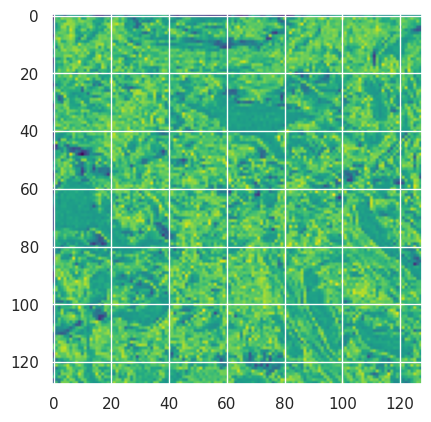

In [17]:
plt.imshow(mu[0][60].cpu().numpy(), cmap='viridis')

## Encoder test

In [22]:
# Define model parameters
in_channels = 3
latent_dim = 512  # you can adjust this
hidden_dims = [32, 64, 128, 256]  # same as your encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Create dummy test input (or use your real tensor)
# test_patch_src_tensor = torch.randn(1, 3, 512, 512).to(device)

# Convert input tensor to device
test_patch_src_tensor = test_patch_src_tensor.to('cuda')

# 3. Instantiate the model
encoder = VanillaEncoder(
    in_channels=3,
    latent_dim=64,  # You can choose a different latent dimension
    hidden_dims=[32, 64, 128],  # same as your encoder,
    learned=True
).to(device)

vae.eval()

# 4. Forward pass
with torch.no_grad():
    encoded = encoder(test_patch_src_tensor)
print("Encoded shape:", encoded.shape)

Encoded shape: torch.Size([1, 64, 64, 64])


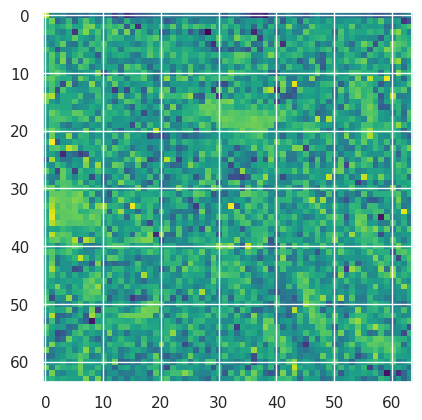

In [23]:
plt.imshow(encoded[0][1].cpu().numpy(),cmap='viridis')

## U-Net model

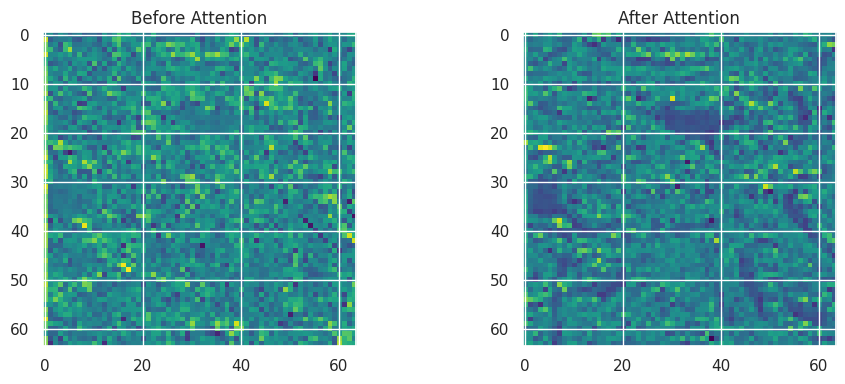

In [24]:
import torch.nn as nn
import matplotlib.pyplot as plt

# Simulate input
x = encoded  # [B, C, H, W]
original = x.clone()

# Flatten for attention
B, C, H, W = x.shape
x_flat = x.view(B, C, H * W).transpose(1, 2)     # [B, 4096, 64]
x_attn = x_flat.transpose(0, 1)                  # [4096, 1, 64]

# Multi-head attention
mha = nn.MultiheadAttention(embed_dim=64, num_heads=4, batch_first=False).cuda()
attn_output, _ = mha(x_attn, x_attn, x_attn)

# Reshape back
attn_output = attn_output.transpose(0, 1)        # [1, 4096, 64]
attn_output = attn_output.transpose(1, 2).view(B, C, H, W)

# Convert tensors to CPU numpy
original_img = original[0, 0].detach().cpu().numpy()  # Channel 0
attn_img = attn_output[0, 0].detach().cpu().numpy()   # Same channel after attention

# Plot before/after
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap='viridis')
plt.title("Before Attention")
# plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(attn_img, cmap='viridis')
plt.title("After Attention")
# plt.axis('off')

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Downsampled Image')

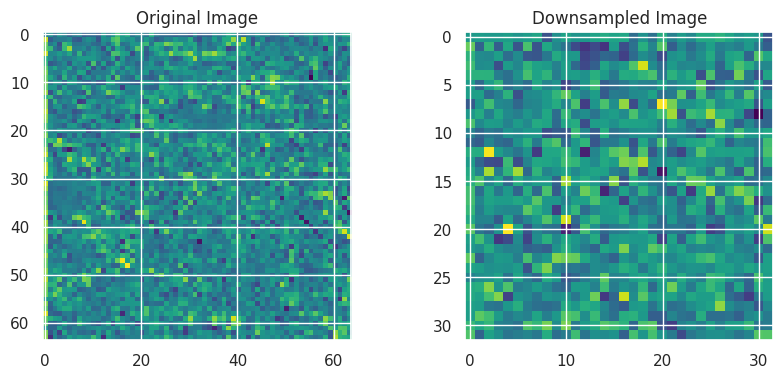

In [25]:
# Instantiate the module
downsample = Downsample(in_channels=64, use_conv=True).to('cuda')

# Create a test input tensor
x = encoded

# Run the forward pass
output = downsample(x)

# Visualize the output image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(x[0][0].cpu().detach().numpy(), cmap='viridis')
plt.title("Original Image")
# Visualize the original image
plt.subplot(1, 2, 2)
plt.imshow(output[0][0].cpu().detach().numpy(), cmap='viridis')
plt.title("Downsampled Image")

Original shape: torch.Size([1, 64, 64, 64])
Upsampled shape: torch.Size([1, 128, 128, 128])


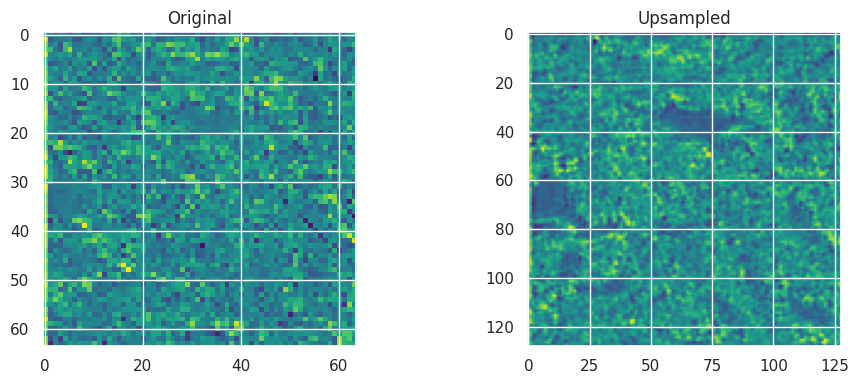

In [28]:
# Test Upsample
upsample = Upsample(in_channels=64, use_conv=True, out_channels=128).cuda()
x = encoded  # Example input
x = x.to('cuda')  # Move to GPU if needed
x_upsampled = upsample(x)
print("Original shape:", x.shape)
print("Upsampled shape:", x_upsampled.shape)
# Visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(x[0, 0].detach().cpu().numpy(), cmap='viridis')  # Channel 0
plt.title("Original")
# plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_upsampled[0, 0].detach().cpu().numpy(), cmap='viridis')  # Channel 0
plt.title("Upsampled")
# plt.axis('off')

plt.tight_layout()
plt.show()

In [35]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define parameters for ResBlock
in_channels = 64  # To match your tensor size
out_channels = 64  # Keep same output channels
emb_channels = 256  # Typical embedding dimension
dropout = 0.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lora_rank = 16

print(f"Using device: {device}")

# Create sample input tensor with size [1, 64, 64, 64]
x =encoded.to('cuda')
print(f"Input tensor shape: {x.shape}")

# Create sample timestep embedding
# Using a random timestep value between 0 and 1000
timestep = torch.tensor([500], device=device)
emb = timestep_embedding(timestep, emb_channels)
print(f"Embedding shape: {emb.shape}")

# Initialize ResBlock
resblock = ResBlock(
    emb_channels=emb_channels,
    dropout=dropout,
    in_channels=in_channels,
    out_channels=out_channels,
    use_scale_shift_norm=True,
    device=device,
    is_trainable=True,
    lora_rank=lora_rank
)
resblock.to(device)

# Forward pass
with torch.no_grad():
    output = resblock(x, emb)

print(f"Output tensor shape: {output.shape}")

# Check if output has the expected shape
assert output.shape == x.shape, f"Expected shape {x.shape} but got {output.shape}"

# Print some statistics about the output
print(f"Output mean: {output.mean().item()}")
print(f"Output std: {output.std().item()}")
print(f"Output min: {output.min().item()}")
print(f"Output max: {output.max().item()}")

print("ResBlock test completed successfully!")

Using device: cuda
Input tensor shape: torch.Size([1, 64, 64, 64])
Embedding shape: torch.Size([1, 256])
Output tensor shape: torch.Size([1, 64, 64, 64])
Output mean: 0.03048834204673767
Output std: 0.6414699554443359
Output min: -4.64255428314209
Output max: 3.968170404434204
ResBlock test completed successfully!


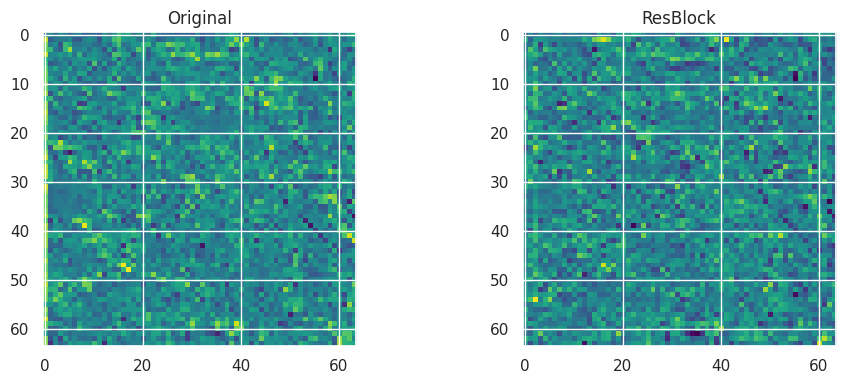

In [36]:
# Visualize output 
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(x[0, 0].detach().cpu().numpy(), cmap='viridis')  # Channel 0
plt.title("Original")
# plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(output[0, 0].detach().cpu().numpy(), cmap='viridis')  # Channel 0
plt.title("ResBlock")
# plt.axis('off')
plt.tight_layout()
plt.show()


In [37]:
output.shape

torch.Size([1, 64, 64, 64])

## Test  Test cross attention

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

z = output.to(device)       # (B, C, H, W)
style = style_emb.to(device)      # (B, N_tokens, D_embed)

model = FlashStyleCrossAttention(z_dim=64, style_dim=512, heads=4).to(device)

with torch.cuda.amp.autocast(enabled=True):
    z_out = model(z, style)

print(f"Input z shape:     {z.shape}")
print(f"Input z dtype:     {z.dtype}")
print(f"Style shape:       {style.shape}")
print(f"Output z_out shape:{z_out.shape}")
print(f"Output z_out dtype:{z_out.dtype}")
print(f"Computation device: {z_out.device}")


Input z shape:     torch.Size([1, 64, 64, 64])
Input z dtype:     torch.float32
Style shape:       torch.Size([1, 512, 64, 64])
Output z_out shape:torch.Size([1, 64, 64, 64])
Output z_out dtype:torch.float16
Computation device: cuda:0


/tmp/ipykernel_11701/4163386001.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Text(0.5, 1.0, 'Output')

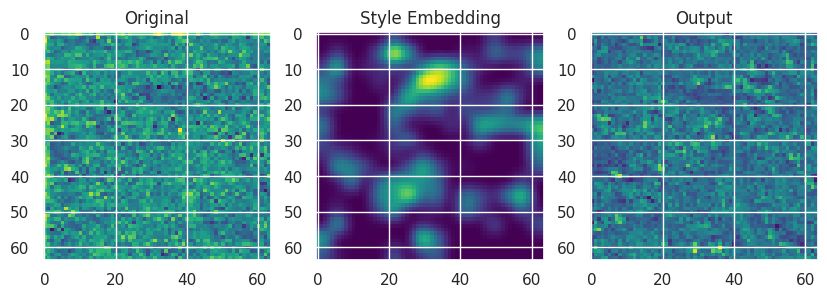

In [43]:
# visualize original and output
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(output[0, 51].detach().cpu().numpy(), cmap='viridis')  # Channel 0
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(style_emb[0, 0].detach().cpu().numpy(), cmap='viridis')  # Channel 0
plt.title("Style Embedding")
# plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(z_out[0][51].cpu().detach().numpy(), cmap='viridis')  # Channel 0
plt.title("Output")

In [44]:
# === TEST ===
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    z = output.to(device)       # (B, C, H, W)
    style = style_emb.to(device)  # (B, C_style, H_style, W_style)

    model = FlashStyleCrossAttention(z_dim=64, style_dim=512, heads=4).to(device)

    with torch.amp.autocast(enabled=True, device_type='cuda'):
        z_out = model(z, style)
        z_out_vis, attention_weights = model(z, style, return_attention=True)

    print(f"Input z shape: {z.shape}")
    print(f"Style shape: {style.shape}")
    print(f"Output shape: {z_out.shape}")

    H, W = z.shape[2], z.shape[3]
    Utilities.visualize_attention(attention_weights, H, W, num_style_tokens=style.shape[2] * style.shape[3])


Input z shape: torch.Size([1, 64, 64, 64])
Style shape: torch.Size([1, 512, 64, 64])
Output shape: torch.Size([1, 64, 64, 64])
Visualization complete! Check 'attention_overview.png' and 'spatial_attention_maps1.png'


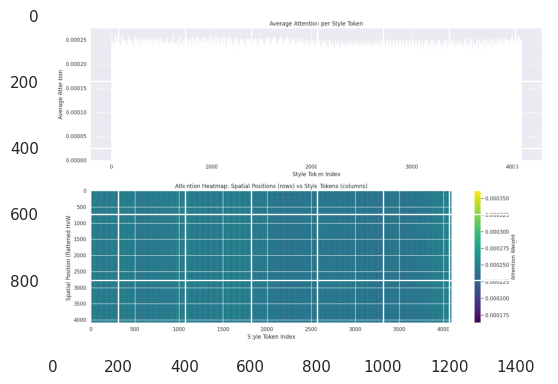

In [46]:
plt.imshow(Image.open("attention_overview.png"))

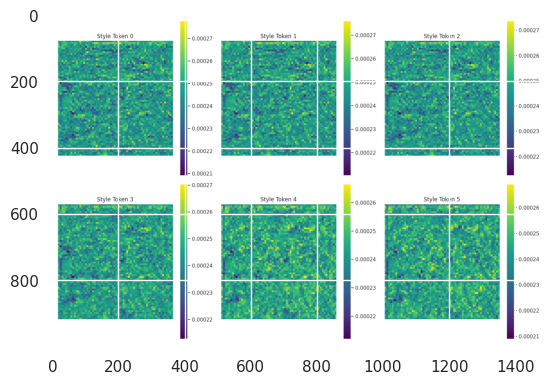

In [49]:
plt.imshow(Image.open("spatial_attention_maps.png"))

---
# First implementation test

In [50]:
# Input conv → [ResBlocks (+Attention) + Downsampling] → Middle (Res+Attention+Res) → [ResBlocks (+Attention) + Upsampling] → Output conv 